# Readout Error Estimation

In this notebook we explore the module `readout.py` that enables 
easy estimation of readout imperfections in the computational basis.

The basic idea is to prepare all possible computational basis states 
and measure the resulting distribution over output strings. For 
input bit strings $i$ and measured output strings $j$ we want to learn all 
values of $\Pr( {\rm detected \ } j
| {\rm prepared \ } i)$. It is convenient to collect these probabilities 
into a matrix which is called a 
[confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix). 
For a single bit $i,j \in \{0, 1 \}$ it is

$$C = 
\begin{pmatrix}
\Pr(0|0) &  \Pr(0|1)\\
\Pr(1|0) &  \Pr(1|1)
\end{pmatrix}
$$
the ideal confusion matrix $ \Pr( j | i ) = \delta_{i,j} $ i.e.
$$
C_{\rm ideal} = 
\begin{pmatrix}
1 &  0\\
0 &  1
\end{pmatrix}$$

Imperfect measurements have $\Pr( j | i ) = C_{j,i}$  where $\sum_j  \Pr( j | i ) =1$ for any $i$.  
  
  
**In summary the functionality of `readout.py` is:**

- estimation of a single qubit confusion matrix
- estimation of the joint confusion matrix over `n` bits
- marginalize a joint confusion matrix over `m` qubits to a smaller matrix over a subset of those qubits
- estimate joint reset confusion matrix


## More Details

Some of the assumptions in the measurement of the confusion matrix
are that the measurement error (aka classical misclassification error) is larger than:
* the ground state preparation error (how thermal is the state)
* the errors introduced by applying $X$ gates to prepare the bit strings
* the quantum aspects of the measurement errors e.g. slightly wrong basis  


When measuring `n` (qu)bits there are $d= 2^n$ possible input and 
output strings. Given perfect preparation of basis state $|k\rangle$ the 
confusion matrix is

$$C = \begin{pmatrix}
p(0 | 0)   & p(0 | 1)   & \cdots & p(0 | {d-1})  \\
p(1 | 0)   & p(1 | 1)   & \cdots & p(1 | {d-1})  \\
\vdots       &              &        & \vdots          \\
p(d-1 | 0) & p(d-1 | 1) & \cdots & p(d-1 | {d-1})
\end{pmatrix}$$

The trace of the confusion matrix divided by the number of states
is the average probability to correctly report the input string

$$F(C):=\frac{\mathrm{Tr}\left( C\right)}{d} = \frac{1}{d} \sum_{j=0}^{d-1} p(j|j)$$

this is some times called the "joint assignment fidelity" or "readout fidelity" of our simultaneous qubit readout.

This matrix can be related to the quantum measurement operators (well the [POVM](https://en.wikipedia.org/wiki/POVM)).
Given the coefficients appearing in the confusion matrix the equivalent readout POVM is

$$\hat N_j := \sum_{k=0}^{d-1} p(j | k) \Pi_{k}$$

where we have introduced the bitstring projectors $\Pi_{k}=|k\rangle \langle k|$. 


To be a valid POVM we must have 

1. $\hat N_j\ge 0$ for all $j$, and 
2. $\sum_j\hat N_j\le I$, 

where $I$ is the identity operator. We can immediately see 
condition one is true. Condition two is easy to verify:

$$\sum_{j=0}^{d-1}\hat N_j 
= \sum_{k=0}^{d-1} \underbrace{\sum_{j=0}^{d-1} p(j | k)}_{1} \hat \Pi_{k}
= \sum_{k=0}^{d-1} \hat \Pi_{k} = I$$

## Simple readout fidelity and confusion matrix estimation

The simple example below should help with understanding the more general code in `readout.py`.

In [1]:
import numpy as np

from pyquil import get_qc
from forest.benchmarking.readout import estimate_confusion_matrix

qc_1q = get_qc('1q-qvm', noisy=True)

`estimate_confusion_matrix` constructs and measures a program for a single qubit for each of the target prep states, either $| 0 \rangle$ or $|1 \rangle$. When $|0 \rangle$ is targeted, we prepare a qubit in the ground state with an identity operation. Similarly, when $|1\rangle$ is targeted, we prepare a qubit in the excited state with an `X` gate. To estimate the confusion matrix we measure each target state many times (default 1000). When we prepare the $|0\rangle$ state we expect to measure the $|0\rangle$ state, so the percentage of the time we do in fact measure $|0\rangle$ gives us an estimate of `p(0|0)`; the remaining fraction of results where we instead measured $|1\rangle$ after preparing $|0\rangle$ gives us an estimate of `p(1|0)`.

In [2]:
confusion_matrix_q0 = estimate_confusion_matrix(qc_1q, 0)
print(confusion_matrix_q0)
print(f'readout fidelity: {np.trace(confusion_matrix_q0)/2}')

[[0.9735 0.0265]
 [0.0928 0.9072]]
readout fidelity: 0.94035


## Generalizing to larger groups of qubits

**Convenient estimation of (possibly joint) confusion matrices for groups of qubits**

The readout module also includes a convenience function for estimating all $k$-qubit confusion matrices for a group of $n \geq k$ qubits; this generalizes the above example, since one could use it to measure a 1-qubit confusion matrix for a group of 1 qubit.

In [3]:
from forest.benchmarking.readout import (estimate_joint_confusion_in_set, 
                                        estimate_joint_reset_confusion, 
                                        marginalize_confusion_matrix)

qc = get_qc('9q-square-noisy-qvm')
qubits = qc.qubits()

In [16]:
# get all single qubit confusion matrices
one_q_ro_conf_matxs = estimate_joint_confusion_in_set(qc, use_active_reset=True)

# get all pairwise confusion matrices from subset of qubits.
subset = qubits[:4]  # only look at 4 qubits of interest, this will mean (4 choose 2) = 6 matrices

two_q_ro_conf_matxs = estimate_joint_confusion_in_set(qc, qubits=subset, joint_group_size=2, use_active_reset=True)

### Extract the one qubit readout (ro) fidelities 

In [17]:
print('Qubit      Readout fidelity')
for qubit in qubits:
    conf_mat = one_q_ro_conf_matxs[(qubit,)]
    ro_fidelity = np.trace(conf_mat)/2 # average P(0 | 0) and P(1 | 1)
    print(f'q{qubit:<3d}{ro_fidelity:15f}')

Qubit      Readout fidelity
q0         0.933500
q1         0.938000
q2         0.934500
q3         0.933000
q4         0.936000
q5         0.942000
q6         0.936500
q7         0.938000
q8         0.939500


### Pick a single two qubit joint confusion matrix and compare marginal to one qubit confusion matrix

Comparing a marginalized joint $n$-qubit matrix to the estimated $k$-qubit ($k<n$) matrices can help reveal correlated errors

In [6]:
two_q_conf_mat = two_q_ro_conf_matxs[(subset[0],subset[-1])]
print('Two qubit confusion matrix:\n',two_q_conf_mat,'\n')

marginal = marginalize_confusion_matrix(two_q_conf_mat, [subset[0], subset[-1]], [subset[0]])

print('Marginal confusion matrix:\n',marginal,'\n')

print('One qubit confusion matrix:\n', one_q_ro_conf_matxs[(subset[0],)])

Two qubit confusion matrix:
 [[0.947 0.027 0.026 0.   ]
 [0.091 0.888 0.003 0.018]
 [0.083 0.004 0.887 0.026]
 [0.01  0.085 0.091 0.814]] 

Marginal confusion matrix:
 [[0.9765 0.0235]
 [0.091  0.909 ]] 

One qubit confusion matrix:
 [[0.971 0.029]
 [0.104 0.896]]


## Plot the confusion matrix

Here we make up a two bit confusion matrix that might represent correlated readout errors, that is a kind of **measurement error crosstalk**.

We can then marginalize and recombine to see how different the independent readout error model would look.

In [39]:
confusion_ideal = np.eye(4)

# if the qubit is in |00> there is probablity to flip
# to |01>, |10>, |11>.
confusion_correlated_two_q_ro_errors = np.array(
    [[0.925, 0.025, 0.025, 0.025],
     [0.000, 1.000, 0.000, 0.000],
     [0.000, 0.000, 1.000, 0.000],
     [0.000, 0.000, 0.000, 1.000]])


marginal1 = marginalize_confusion_matrix(confusion_correlated_two_q_ro_errors, [0, 1], [0])
marginal2 = marginalize_confusion_matrix(confusion_correlated_two_q_ro_errors, [0, 1], [1])

# take the two marginal confusion matrices and recombine
recombine = np.kron(marginal1, marginal2)

In [40]:
from forest.benchmarking.plotting.hinton import hinton_real
import itertools
import matplotlib.pyplot as plt

In [41]:
one_bit_labels = ['0','1']
two_bit_labels = [''.join(x) for x in itertools.product('01', repeat=2)]

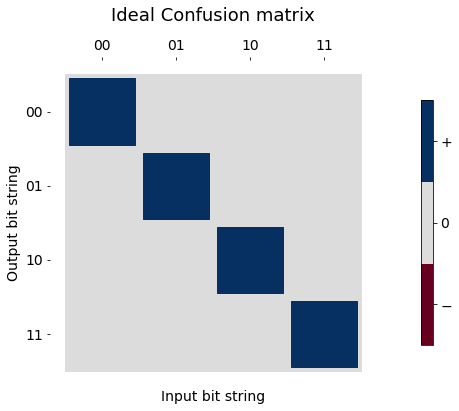

In [42]:
fig0, ax0 = hinton_real(confusion_ideal, xlabels=two_bit_labels, ylabels=two_bit_labels, title='Ideal Confusion matrix')
ax0.set_xlabel("Input bit string", fontsize=14)
ax0.set_ylabel("Output bit string", fontsize=14);

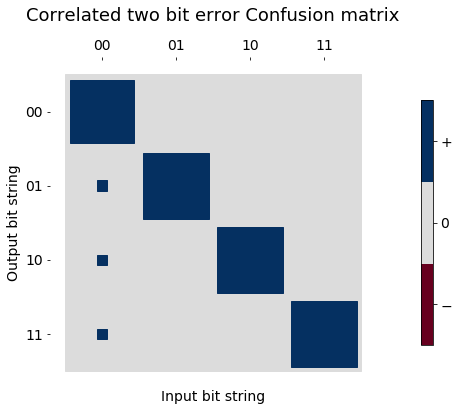

In [43]:
fig1, ax1 = hinton_real(confusion_correlated_two_q_ro_errors, xlabels=two_bit_labels, ylabels=two_bit_labels, title='Correlated two bit error Confusion matrix')
ax1.set_xlabel("Input bit string", fontsize=14)
ax1.set_ylabel("Output bit string", fontsize=14);

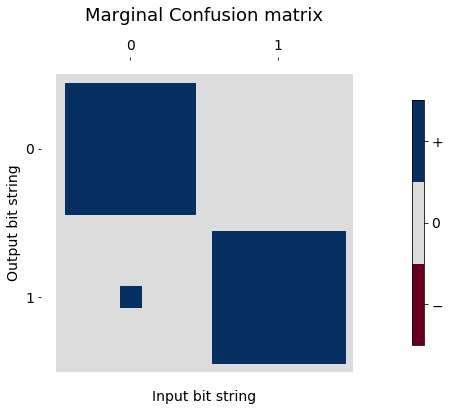

In [44]:
fig2, ax2 = hinton_real(marginal1, xlabels=one_bit_labels, ylabels=one_bit_labels, title='Marginal Confusion matrix')
ax2.set_xlabel("Input bit string", fontsize=14)
ax2.set_ylabel("Output bit string", fontsize=14);

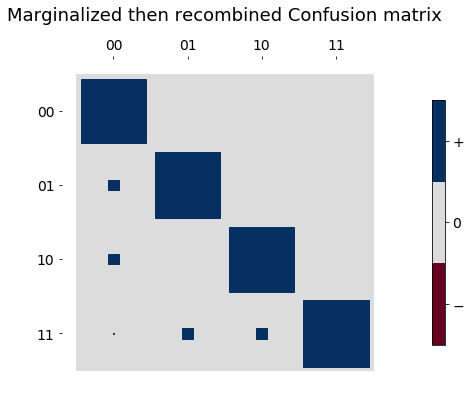

In [45]:
fig3, ax3 = hinton_real(recombine, xlabels=two_bit_labels, ylabels=two_bit_labels, title='Marginalized then recombined Confusion matrix')
ax2.set_xlabel("Input bit string", fontsize=14)
ax2.set_ylabel("Output bit string", fontsize=14);

## Estimate confusion matrix for active reset error

Similarly to readout, we can estimate a confusion matrix to see how well active reset is able to reset any given bitstring to the ground state ($|0\dots 0\rangle$). 

In [7]:
subset = tuple(qubits[:4])
subset_reset_conf_matx = estimate_joint_reset_confusion(qc, subset, 
                                                        joint_group_size=len(subset), 
                                                        show_progress_bar=True)

100%|██████████| 16/16 [00:40<00:00,  2.61s/it]


In [8]:
for row in subset_reset_conf_matx[subset]:
    pr_sucess = row[0]
    print(pr_sucess)

0.7
0.8999999999999999
0.8999999999999999
0.9999999999999999
0.9999999999999999
0.9999999999999999
0.9999999999999999
0.9999999999999999
0.7999999999999999
0.9999999999999999
0.7
0.9999999999999999
0.7999999999999999
0.8999999999999999
0.7
0.8999999999999999
